# Mental health in the pregnancy during the COVID-19

## 1. Setup

### 1.1 Dataset

In [33]:
!pip install xgboost

In [34]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

# Set the random seed for reproducibility
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED) # According to the UniKey
# Set the options for the pandas library to avoid future warnings
# pd.set_option('future.no_silent_downcasting', True)
# Set the style for the matploftlib library
plt.style.use('ggplot')
height = 6
aspect = 8 / height

In [35]:
# Load the data
df = pd.read_csv('./data_cleaned.csv')
df.head(5)


,OSF_ID,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Delivery_Date,Birth_Length,Birth_Weight,...,Threaten_Baby_Harm,Language_English,Language_French,Delivery_Mode_Vaginally,Delivery_Mode_C-section,Delivery_Mode_Unknown,NICU_Stay_Yes,NICU_Stay_No,NICU_Stay_Unknown,Delivery_Mode
0,1,38.3,9,5,9,13,39.710000,2020-12-01 00:00:00.000000000,49.200000,3.431000,...,27,1,0,1,0,0,0,1,0,Vaginally
1,2,34.6,9,4,4,17,38.128942,2020-09-05 11:24:10.781531136,55.646138,3.074790,...,92,1,0,0,0,1,0,0,1,Unknown
2,4,28.8,5,5,9,20,38.570000,2020-12-01 00:00:00.000000000,41.000000,2.534000,...,54,0,1,1,0,0,0,1,0,Vaginally
3,5,36.5,3,4,14,20,39.860000,2020-10-01 00:00:00.000000000,53.340000,3.714000,...,71,1,0,0,1,0,0,1,0,C-section
4,6,38.3,7,4,3,8,38.570000,2020-06-01 00:00:00.000000000,53.980190,3.464328,...,33,1,0,0,0,1,0,0,1,Unknown


In [36]:
# Check the data complexity
df.shape

(9566, 22)

In [37]:
# Check the basic information of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9566 entries, 0 to 9565
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   OSF_ID                                9566 non-null   int64  
 1   Maternal_Age                          9566 non-null   float64
 2   Household_Income                      9566 non-null   int64  
 3   Maternal_Education                    9566 non-null   int64  
 4   Edinburgh_Postnatal_Depression_Scale  9566 non-null   int64  
 5   PROMIS_Anxiety                        9566 non-null   int64  
 6   Gestational_Age_At_Birth              9566 non-null   float64
 7   Delivery_Date                         9566 non-null   object 
 8   Birth_Length                          9566 non-null   float64
 9   Birth_Weight                          9566 non-null   float64
 10  Threaten_Life                         9566 non-null   int64  
 11  Threaten_Baby_Dan

### 1.2 Modelling agreements

Our goal of this research is to know what data columns will effect the 'Edinburgh Postnatal Depression Scale' and 'PROMIS_Anxiety'.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4928679/#R8

https://www.healthmeasures.net/score-and-interpret/interpret-scores/promis/promis-score-cut-points

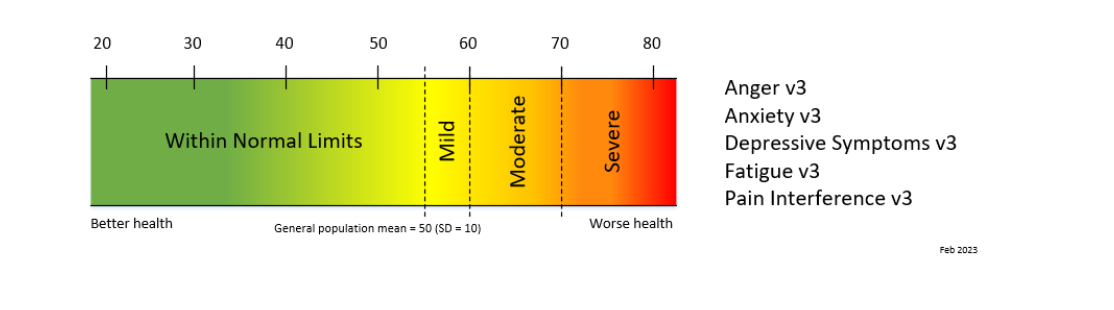

https://www.healthmeasures.net/administrator/components/com_instruments/uploads/PROMIS%20Anxiety%20Scoring%20Manual_08Sept2023.pdf

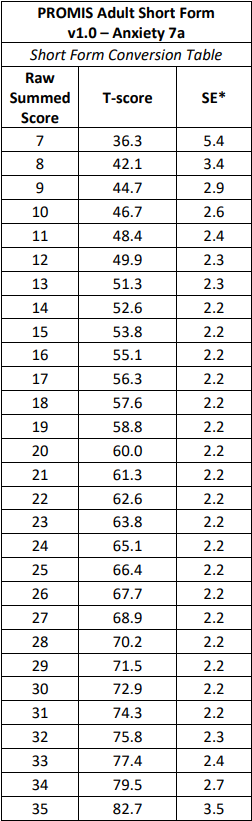


According upper links and images we could know that.

- __Edinburgh Postnatal Depression Scale (EPDS) :__

    - 0-9: Indicates minimal to no depression symptoms.

    - 10-12: Suggests mild depression symptoms. Further evaluation may be needed.

    - 13-15: Indicates moderate depression symptoms. Professional evaluation and support are recommended.

    - 16 or higher: Suggests severe depression symptoms. Immediate professional help and intervention are necessary.
    
- __PROMIS Anxiety(T-Score Metric) :__
    - Scores Below 55: Within Normal Limits

    - Scores 55-60: Mild

    - Scores 60-70: Moderate

    - Scores Above 70: Severe

In [38]:
# Categorize EPDS scores
def categorize_epds(score):
    # Within Normal Limits
    if score <= 9:
        return 0
    # Mild
    elif score <= 12:
        return 1
    # Moderate
    elif score <= 15:
        return 2
    # Severe
    else:
        return 3

df['Edinburgh_Postnatal_Depression_Scale'] = df['Edinburgh_Postnatal_Depression_Scale'].apply(categorize_epds)

# Categorize PROMIS Anxiety scores
def categorize_promis(score):
    # Within Normal Limits
    if score < 16:
        return 0
    # Mild
    elif score <= 20:
        return 1
    # Moderate
    elif score <= 28:
        return 2
    # Severe
    else:
        return 3

df['PROMIS_Anxiety'] = df['PROMIS_Anxiety'].apply(categorize_promis)

In [39]:
# Check the distribution of the Edinburgh_Postnatal_Depression_Scale
epds_distribution = df['Edinburgh_Postnatal_Depression_Scale'].value_counts().sort_index()
print("EPDS Distribution:")
print(epds_distribution)

# Check the distribution of the PROMIS Anxiety
promis_distribution = df['PROMIS_Anxiety'].value_counts().sort_index()
print("\nPROMIS Anxiety Distribution:")
print(promis_distribution)

EPDS Distribution:
Edinburgh_Postnatal_Depression_Scale
0    4468
1    1915
2    1568
3    1615
Name: count, dtype: int64

PROMIS Anxiety Distribution:
PROMIS_Anxiety
0    3084
1    2685
2    3394
3     403
Name: count, dtype: int64


"Raw scores are provided for the Edinburgh Postnatal Depression Scale (EPDS) and the PROMIS Anxiety scale. Ratings are given for three different variables describing the fear that COVID-19 would threaten their own lives (threaten_life), threaten their unborn baby's life (threaten_baby_danger), or harm their baby (threaten_baby_harm)."

Which is get from the original report.

In [40]:
# Assume df['Delivery_Date'] is already a datetime column
df['Delivery_Date'] = pd.to_datetime(df['Delivery_Date'])

# Find the minimum date in the 'Delivery_Date' column
min_date = df['Delivery_Date'].min()

# Calculate the number of years since the minimum date for each entry
df['Delivery_Date'] = (df['Delivery_Date'] - min_date).dt.days / 365

# Optionally, if you want to round the result or truncate to whole years, you could do either:
df['Delivery_Date'] = df['Delivery_Date'].round()  # Round to nearest year
# or
df['Delivery_Date'] = df['Delivery_Date'].astype(int)  # Truncate to whole years


In [41]:
# Plot the correlation matrix
df.drop('Delivery_Mode', axis=1, inplace=True)
corr_matrix = df.corr()

In [42]:
corr_matrix.loc['PROMIS_Anxiety', :].sort_values(ascending=False)

PROMIS_Anxiety                          1.000000
Edinburgh_Postnatal_Depression_Scale    0.709872
Threaten_Baby_Danger                    0.346515
Threaten_Life                           0.329116
Threaten_Baby_Harm                      0.320091
Language_English                        0.078491
NICU_Stay_Unknown                       0.053993
Delivery_Mode_Unknown                   0.053617
NICU_Stay_Yes                           0.038609
Delivery_Mode_C-section                 0.004535
OSF_ID                                 -0.009623
Birth_Weight                           -0.032585
Gestational_Age_At_Birth               -0.035143
Delivery_Date                          -0.048039
Delivery_Mode_Vaginally                -0.058227
Birth_Length                           -0.066601
NICU_Stay_No                           -0.071101
Language_French                        -0.078491
Maternal_Age                           -0.087668
Maternal_Education                     -0.121831
Household_Income    

In [43]:
corr_matrix.loc['Edinburgh_Postnatal_Depression_Scale', :].sort_values(ascending=False)

Edinburgh_Postnatal_Depression_Scale    1.000000
PROMIS_Anxiety                          0.709872
Threaten_Baby_Danger                    0.292373
Threaten_Life                           0.271075
Threaten_Baby_Harm                      0.251707
NICU_Stay_Unknown                       0.088085
Delivery_Mode_Unknown                   0.087557
Language_English                        0.049117
NICU_Stay_Yes                           0.025049
OSF_ID                                  0.004373
Delivery_Mode_C-section                -0.011429
Gestational_Age_At_Birth               -0.042146
Language_French                        -0.049117
Birth_Weight                           -0.050958
Delivery_Date                          -0.052367
Delivery_Mode_Vaginally                -0.080908
Maternal_Age                           -0.087357
Birth_Length                           -0.088487
NICU_Stay_No                           -0.098962
Maternal_Education                     -0.162792
Household_Income    

As we can see than both 'Edinburgh_Postnatal_Depression_Scale' and 'PROMIS_Anxiety' have strong correlation with 'Threaten_Baby_Danger' 'Threaten_Life' 'Threaten_Baby_Harm' rate.  Thy both have very high correlation which is 0.709872.

(But the 'PROMIS_Anxiety' have slightly higher correlation score than 'Edinburgh_Postnatal_Depression_Scale' then we will choose 'PROMIS_Anxiety' as the main predicted attribute.) !!! Depend on the result !!!

https://medium.com/@sujathamudadla1213/why-we-have-to-remove-highly-correlated-features-in-machine-learning-9a8416286f18#:~:text=In%20machine%20learning%2C%20highly%20correlated,removing%20them%20is%20often%20beneficial.

https://campus.datacamp.com/courses/dimensionality-reduction-in-python/feature-selection-i-selecting-for-feature-information?ex=13#:~:text=Features%20that%20are%20perfectly%20correlated,that%20hold%20the%20same%20information.

So in future research we will focus on the 

## 2. Predictive model

### 2.1 Model description

https://dl.acm.org/doi/pdf/10.1145/2939672.2939785

### 2.2 Model development

First fine tun ['PROMIS_Anxiety'] with ['Threaten_Life', 'Threaten_Baby_Danger', 'Threaten_Baby_Harm']

In [12]:
# define a function to train an XGBoost model which could save a lot of space in future
def train_xgb_model(X, y, param_grid, test_size=0.2, cv=3, verbose=1, RANDOM_SEED=42):
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=RANDOM_SEED)

    # Define the model with GPU support
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',  # Multi-class softmax objective
        num_class=len(set(y_train)),  # Number of unique classes
        tree_method="hist",
        device="cuda",
        random_state=RANDOM_SEED
    )

    # Train the model
    xgb_model.fit(X_train, y_train)

    # Setup GridSearchCV
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=verbose)

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Output the best parameters and cross-validation score
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

    # Return the best model
    return grid_search.best_estimator_

In [14]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [5, 10, 50],
    'subsample': [0.8, 0.9, 1.0]
}

# Assuming df is predefined with relevant features and target
X = df[['Threaten_Life', 'Threaten_Baby_Danger', 'Threaten_Baby_Harm']]
y = df['PROMIS_Anxiety']

best_model = train_xgb_model(X, y, param_grid)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 75, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
Best cross-validation score: 0.46


Second time fine tun ['PROMIS_Anxiety'] with ['Threaten_Life', 'Threaten_Baby_Danger', 'Threaten_Baby_Harm'] with smaller range

In [19]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.0025,0.005,0.0075],
    'n_estimators': [30, 50, 70],
    'subsample': [0.3,0.5,0.7],
    'subsample': [0.8],
    'colsample_bytree':[0.8],
    'reg_alpha':[0.1],
    'reg_lambda':[0.1],
}

best_model = train_xgb_model(X, y, param_grid)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 3, 'n_estimators': 70, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
Best cross-validation score: 0.46


As we can see with those data and with second time fine tune the cross validation score still stay at 0.46.</br>
So if we want to improve the score the best way is to using more relative training feature or try the 'Edinburgh_Postnatal_Depression_Scale' as the predict value.  Because 'Edinburgh_Postnatal_Depression_Scale' and 'PROMIS_Anxiety' have siminear similar meaning in this data set. 

In [17]:
# Setup data
X = df[['Threaten_Life', 'Threaten_Baby_Danger', 'Threaten_Baby_Harm']]
y = df['Edinburgh_Postnatal_Depression_Scale']

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.0025,0.005,0.0075],
    'n_estimators': [30, 50, 70],
    'subsample': [0.3,0.5,0.7],
    'subsample': [0.8],
    'colsample_bytree':[0.8],
    'reg_alpha':[0.1],
    'reg_lambda':[0.1],
}

best_model = train_xgb_model(X, y, param_grid)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.0025, 'max_depth': 3, 'n_estimators': 30, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
Best cross-validation score: 0.48


As we can see 'Edinburgh_Postnatal_Depression_Scale' performance is slightly better than 'PROMIS_Anxiety' which score is 0.48</br>
But it is still preaty low. So if we want to improve the score the best way is to using more relative training feature for example put the 'PROMIS_Anxiety' into the training set or  'Edinburgh_Postnatal_Depression_Scale' into the training set.

In [24]:
# Setup data
X = df[['Threaten_Life', 'Threaten_Baby_Danger', 'Threaten_Baby_Harm','PROMIS_Anxiety']]
y = df['Edinburgh_Postnatal_Depression_Scale']

# Create a parameter grid
param_grid = {
    'max_depth': [3,5,10],
    'learning_rate': [0.001,0.01],
    'n_estimators': [10,20,50],
    'subsample': [0.8],
    'colsample_bytree':[0.8],
    'reg_alpha':[0.1],
    'reg_lambda':[0.1],
}

best_model = train_xgb_model(X, y, param_grid)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
Best cross-validation score: 0.58


As we can see the score have signlificant improve which is improved from 0.48 to 0.58.</br>
So why not try to put 'Edinburgh_Postnatal_Depression_Scale' into training set and 'PROMIS_Anxiety' into predict set.

In [16]:
# Setup data
X = df[['Threaten_Life', 'Threaten_Baby_Danger', 'Threaten_Baby_Harm','Edinburgh_Postnatal_Depression_Scale']]
y = df['PROMIS_Anxiety']

# Create a parameter grid
param_grid = {
    'max_depth': [3,5,10],
    'learning_rate': [0.001,0.01],
    'n_estimators': [10,20,50],
    'subsample': [0.8],
    'colsample_bytree':[0.8],
    'reg_alpha':[0.1],
    'reg_lambda':[0.1],
}

best_model = train_xgb_model(X, y, param_grid)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 20, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
Best cross-validation score: 0.61


Above result is much better than the original 0.46 score.</br>
So why not try to put all the feature rather than 'PROMIS_Anxiety' into the training set. Which might could improve the proformance.

In [26]:
# Setup data
X = df.drop(columns=['PROMIS_Anxiety'])
y = df['PROMIS_Anxiety']

# Create a parameter grid
param_grid = {
    'max_depth': [3,10,50],
    'learning_rate': [0.001,0.01],
    'n_estimators': [10,50,100],
    'subsample': [0.8],
    'colsample_bytree':[0.8],
    'reg_alpha':[0.1],
    'reg_lambda':[0.1],
}

best_model = train_xgb_model(X, y, param_grid)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
Best cross-validation score: 0.61


In [29]:
# Setup data
X = df.drop(columns=['Edinburgh_Postnatal_Depression_Scale'])
y = df['Edinburgh_Postnatal_Depression_Scale']

# Create a parameter grid
param_grid = {
    'max_depth': [3,10,50],
    'learning_rate': [0.001,0.01],
    'n_estimators': [10,50,100],
    'subsample': [0.8],
    'colsample_bytree':[0.8],
    'reg_alpha':[0.1],
    'reg_lambda':[0.1],
}

best_model = train_xgb_model(X, y, param_grid)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
Best cross-validation score: 0.61


As we can see compared with the hightest score with the training set with all featrue and training set just have a few main feature.</br>
The training set have few main feature have the faster compile time and higher score so in next few block I will try to find more feature to improve the model performance. 

In [107]:
# Setup data
X = df[['Threaten_Life', 'Threaten_Baby_Danger', 'Threaten_Baby_Harm','Edinburgh_Postnatal_Depression_Scale','Delivery_Date','NICU_Stay_Yes']]
y = df['PROMIS_Anxiety']

# Create a parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.0025,0.005,0.0075],
    'n_estimators': [30, 50, 70],
    'subsample': [0.3,0.5,0.7],
    'subsample': [0.8],
    'colsample_bytree':[0.8],
    'reg_alpha':[0.1],
    'reg_lambda':[0.1],
}

best_model = train_xgb_model(X, y, param_grid)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
Best cross-validation score: 0.61


In [106]:
# Setup data
X = df[['Threaten_Life', 'Threaten_Baby_Danger', 'Threaten_Baby_Harm','PROMIS_Anxiety','Delivery_Date','NICU_Stay_Yes']]
y = df['Edinburgh_Postnatal_Depression_Scale']

# Create a parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.0025,0.005,0.0075],
    'n_estimators': [30, 50, 70],
    'subsample': [0.3,0.5,0.7],
    'subsample': [0.8],
    'colsample_bytree':[0.8],
    'reg_alpha':[0.1],
    'reg_lambda':[0.1],
}

best_model = train_xgb_model(X, y, param_grid)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.0075, 'max_depth': 5, 'n_estimators': 30, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
Best cross-validation score: 0.57


So in the end we will choose 'PROMIS_Anxiety' as prediction data set. 'Threaten_Life', 'Threaten_Baby_Danger', 'Threaten_Baby_Harm','Edinburgh_Postnatal_Depression_Scale' to be the training data set.</br>
The first reason is that it have the highest cross validation score.  The other reason is that all the training data set have the highest coreelation score.  Also it have strong corelation in real life.</br>
In below we will try to use more parameter to make sure it have the highest score.

In [24]:
# Setup data
X = df[['Threaten_Life', 'Threaten_Baby_Danger', 'Threaten_Baby_Harm','Edinburgh_Postnatal_Depression_Scale']]
y = df['PROMIS_Anxiety']

# Create a parameter grid
param_grid = {
    'max_depth': [3,5,10],
    'learning_rate': [0.001,0.01],
    'n_estimators': [10,20,50],
    'subsample': [0.8],
    'colsample_bytree':[0.8],
    'reg_alpha':[0.1],
    'reg_lambda':[0.1],
}

best_model = train_xgb_model(X, y, param_grid)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 20, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
Best cross-validation score: 0.61
F1 Score: 0.42
Precision: 0.45
ROC-AUC Score: 0.83


c:\Users\GGarry\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 3. Model evaluation and optimization

Code without the sample_weights and grid search and cross validation

In [62]:
# define a function to train an XGBoost model which could save a lot of space in future
def train_xgb_model(X, y, test_size=0.2, cv=3, verbose=1, RANDOM_SEED=0):
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=RANDOM_SEED)

    # Define the model with GPU support
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',  # Multi-class softmax objective
        num_class=len(set(y_train)),  # Number of unique classes
        tree_method="hist",
        device="cuda",
        random_state=RANDOM_SEED
    )
        
        # Fit model on training data
    xgb_model.fit(X_train, y_train)

        # Evaluate model
    y_pred = xgb_model.predict(X_test)

    # Make predictions on the test set
    y_pred = xgb_model.predict(X_test)
    
    # Calculate metrics
    f1 = f1_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test), multi_class='ovr')
    
    print("F1 Score: {:.2f}".format(f1))
    print("Precision: {:.2f}".format(precision))
    print("ROC-AUC Score: {:.2f}".format(roc_auc))

    # Return the best model
    return xgb_model

# Assuming 'df' is your DataFrame
# Setup data
X = df[['Threaten_Life', 'Threaten_Baby_Danger', 'Threaten_Baby_Harm','PROMIS_Anxiety']]
y = df['Edinburgh_Postnatal_Depression_Scale']

best_model = train_xgb_model(X, y)


F1 Score: 0.43
Precision: 0.43
ROC-AUC Score: 0.76


Code without the sample_weights

In [63]:


# define a function to train an XGBoost model which could save a lot of space in future
def train_xgb_model(X, y, param_grid, test_size=0.2, cv=3, verbose=1, RANDOM_SEED=0):
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=RANDOM_SEED)

    # Define the model with GPU support
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',  # Multi-class softmax objective
        num_class=len(set(y_train)),  # Number of unique classes
        tree_method="hist",
        device="cuda",
        random_state=RANDOM_SEED
    )

    # Setup GridSearchCV
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=verbose)
    
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Output the best parameters and cross-validation score
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

    # Make predictions on the test set
    y_pred = grid_search.best_estimator_.predict(X_test)
    
    # Calculate metrics
    f1 = f1_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    roc_auc = roc_auc_score(y_test, grid_search.best_estimator_.predict_proba(X_test), multi_class='ovr')
    
    print("F1 Score: {:.2f}".format(f1))
    print("Precision: {:.2f}".format(precision))
    print("ROC-AUC Score: {:.2f}".format(roc_auc))

    # Return the best model
    return grid_search.best_estimator_

# Assuming 'df' is your DataFrame
# Setup data
X = df[['Threaten_Life', 'Threaten_Baby_Danger', 'Threaten_Baby_Harm','PROMIS_Anxiety']]
y = df['Edinburgh_Postnatal_Depression_Scale']

# Create a parameter grid
param_grid = {
    'max_depth': [3,5,10],
    'learning_rate': [0.001,0.01],
    'n_estimators': [10,20,50],
    'subsample': [0.8],
    'colsample_bytree':[0.8],
    'reg_alpha':[0.1],
    'reg_lambda':[0.1],
}

best_model = train_xgb_model(X, y, param_grid)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
Best cross-validation score: 0.58
F1 Score: 0.41
Precision: 0.37
ROC-AUC Score: 0.79


c:\Users\GGarry\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


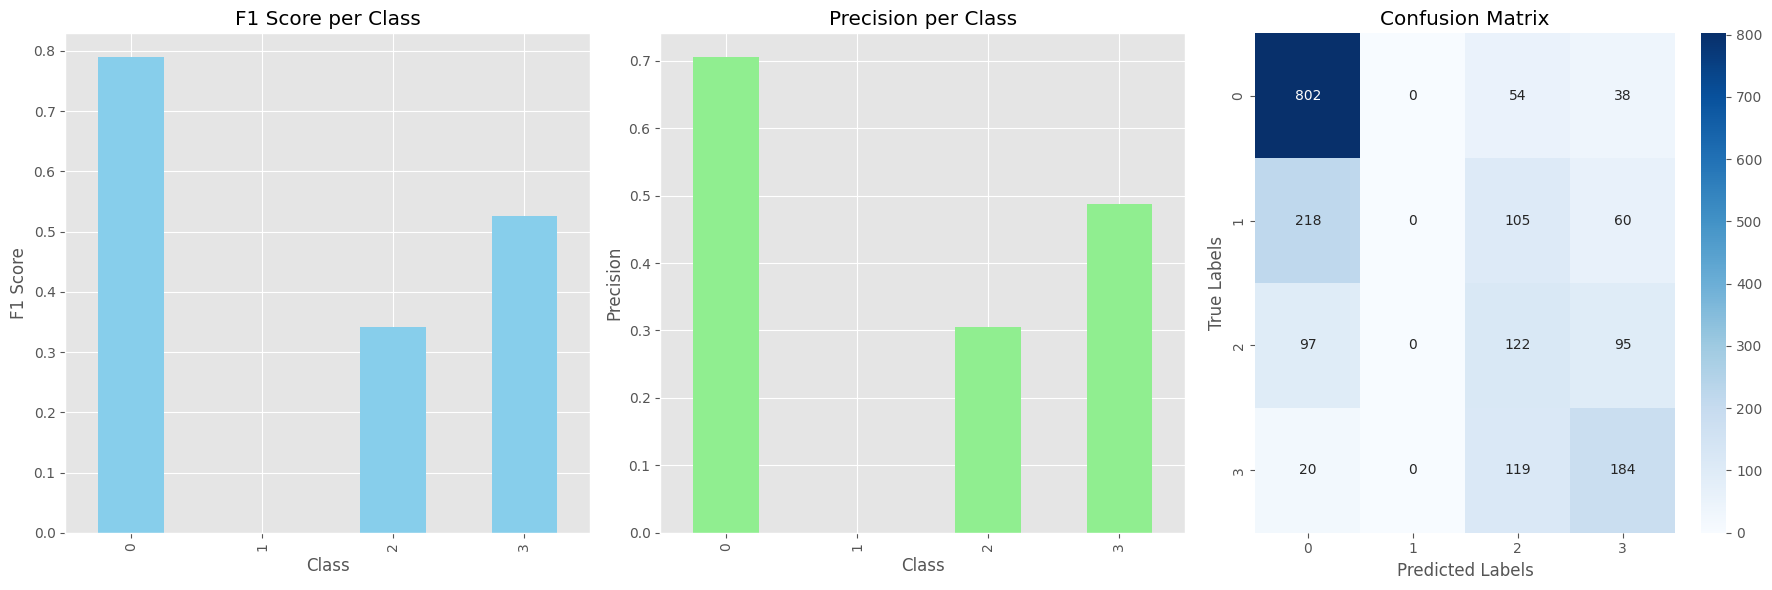

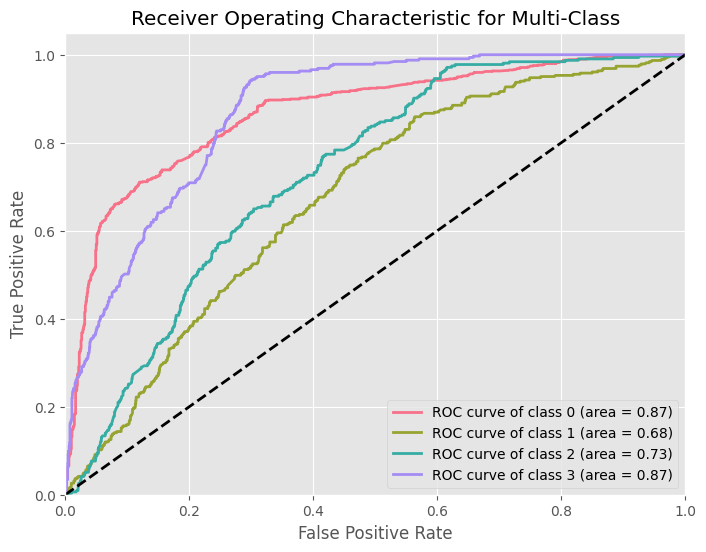

              precision    recall  f1-score      support
0              0.705365  0.897092  0.789759   894.000000
1              0.000000  0.000000  0.000000   383.000000
2              0.305000  0.388535  0.341737   314.000000
3              0.488064  0.569659  0.525714   323.000000
accuracy       0.578892  0.578892  0.578892     0.578892
macro avg      0.374607  0.463822  0.414302  1914.000000
weighted avg   0.461866  0.578892  0.513665  1914.000000


In [66]:
def plot_metrics(X, y, model):
    # Generate train/test splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
    
    # Train model and make predictions
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
    
    # Binarize the output
    y_test_bin = label_binarize(y_test, classes=np.unique(y))
    n_classes = y_test_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute classification report with zero_division handling
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    df_report = pd.DataFrame(report).transpose()

    # Plotting F1 score and Precision
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    df_report['f1-score'].drop(['accuracy', 'macro avg', 'weighted avg']).plot(kind='bar', ax=ax[0], color='skyblue')
    ax[0].set_title('F1 Score per Class')
    ax[0].set_ylabel('F1 Score')
    ax[0].set_xlabel('Class')
    df_report['precision'].drop(['accuracy', 'macro avg', 'weighted avg']).plot(kind='bar', ax=ax[1], color='lightgreen')
    ax[1].set_title('Precision per Class')
    ax[1].set_ylabel('Precision')
    ax[1].set_xlabel('Class')

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[2])
    ax[2].set_title('Confusion Matrix')
    ax[2].set_xlabel('Predicted Labels')
    ax[2].set_ylabel('True Labels')
    ax[2].set_xticklabels(np.unique(y))
    ax[2].set_yticklabels(np.unique(y))
    
    plt.tight_layout()
    plt.show()

    # cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
    # plt.figure(figsize=(6, 6))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    # plt.title('Confusion Matrix')
    # plt.xlabel('Predicted Labels')
    # plt.ylabel('True Labels')
    # plt.xticks(np.arange(len(np.unique(y))) + 0.5, np.unique(y))
    # plt.yticks(np.arange(len(np.unique(y))) + 0.5, np.unique(y))
    # plt.tight_layout()
    # plt.show()


    # Plotting ROC-AUC
    plt.figure(figsize=(8, 6))
    colors = sns.color_palette("husl", n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Multi-Class')
    plt.legend(loc="lower right")
    plt.show()

    # Print the classification report
    print(df_report)

# Assuming you have a trained model 'best_model' and data 'X', 'y'
plot_metrics(X, y, best_model)


As we can see the class  F1 score and Precision is 0. Which meas this model just cannot predict correctly in the class 3. </br>
After some research I found that the 'sample_weights' are computed based on class weights. These sample weights are used to give more importance to samples from underrepresented classes during training, thereby helping to balance the impact of class imbalances in the dataset.

In [67]:
# This function computes class weights inversely proportional to class frequencies in the input data
def get_class_weights(y):
    classes = np.unique(y)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    return dict(zip(classes, class_weights))

from sklearn.model_selection import train_test_split, GridSearchCV

def train_xgb_model(X, y, param_grid, test_size=0.2, cv=5, verbose=1, RANDOM_SEED=0):
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=RANDOM_SEED)
    
    # Compute class weights
    class_weights = get_class_weights(y_train)
    
    # Define the model with GPU support and pass class weights
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(set(y_train)),
        tree_method="hist",
        device="cuda",
        random_state=RANDOM_SEED
    )

    # Setup GridSearchCV
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=verbose)
    
    # Calculate sample weights for each instance in the training set
    sample_weights = np.array([class_weights[y] for y in y_train])
    
    # Fit GridSearchCV with sample weights
    grid_search.fit(X_train, y_train, sample_weight=sample_weights)

    # Output the best parameters and cross-validation score
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

    # Make predictions on the test set
    y_pred = grid_search.best_estimator_.predict(X_test)
    
    # Calculate metrics
    f1 = f1_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    roc_auc = roc_auc_score(y_test, grid_search.best_estimator_.predict_proba(X_test), multi_class='ovr')
    
    print("F1 Score: {:.2f}".format(f1))
    print("Precision: {:.2f}".format(precision))
    print("ROC-AUC Score: {:.2f}".format(roc_auc))

    # Return the best model
    return grid_search.best_estimator_

# Assuming 'df' is your DataFrame
# Setup data
X = df[['Threaten_Life', 'Threaten_Baby_Danger', 'Threaten_Baby_Harm','PROMIS_Anxiety']]
y = df['Edinburgh_Postnatal_Depression_Scale']

# Create a parameter grid
param_grid = {
    'max_depth': [5,10,15],
    'learning_rate': [0.001,0.01],
    'n_estimators': [10,50,100],
    'subsample': [0.8],
    'colsample_bytree':[0.8],
    'reg_alpha':[0.1],
    'reg_lambda':[0.1],
}

best_model = train_xgb_model(X, y, param_grid)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
Best cross-validation score: 0.54
F1 Score: 0.47
Precision: 0.47
ROC-AUC Score: 0.77


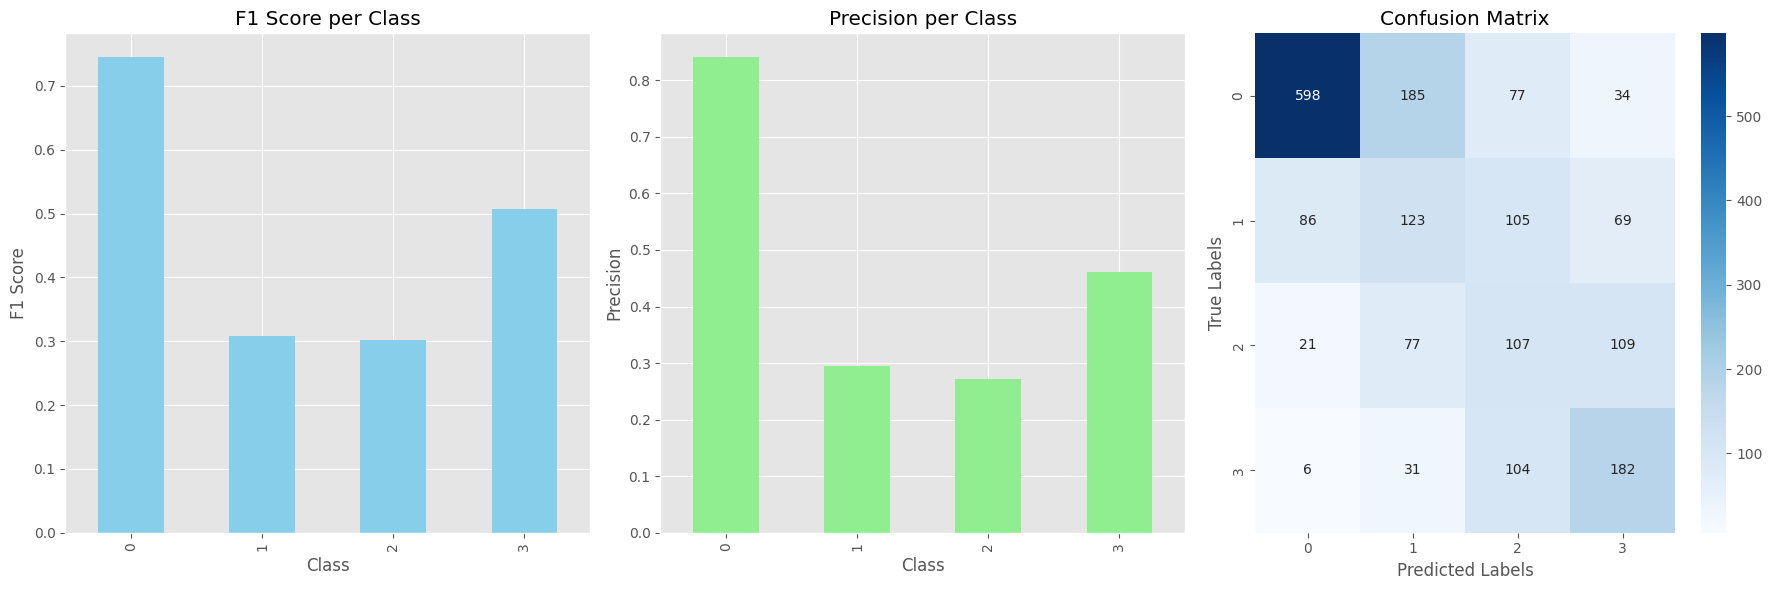

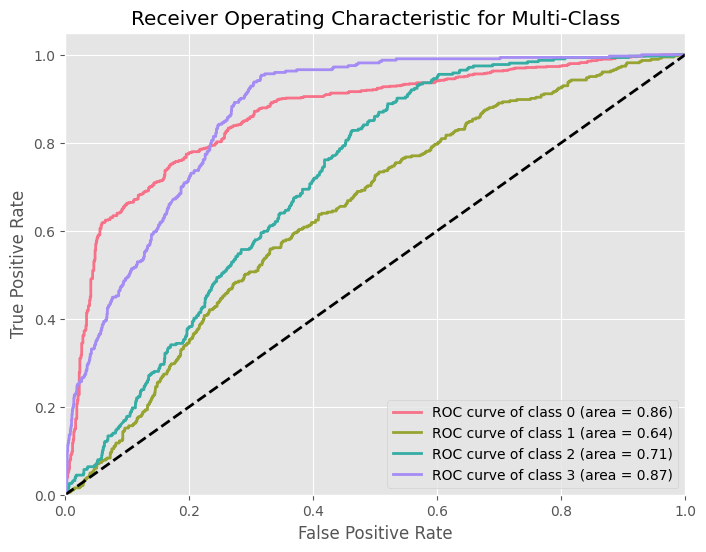

              precision    recall  f1-score      support
0              0.841069  0.668904  0.745171   894.000000
1              0.295673  0.321149  0.307885   383.000000
2              0.272265  0.340764  0.302687   314.000000
3              0.461929  0.563467  0.507671   323.000000
accuracy       0.527691  0.527691  0.527691     0.527691
macro avg      0.467734  0.473571  0.465854  1914.000000
weighted avg   0.574636  0.527691  0.544997  1914.000000


In [70]:

def plot_metrics(X, y, model):
    # Generate train/test splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
    
    # Train model and make predictions
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
    
    # Binarize the output
    y_test_bin = label_binarize(y_test, classes=np.unique(y))
    n_classes = y_test_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute classification report with zero_division handling
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    df_report = pd.DataFrame(report).transpose()

    # Plotting F1 score and Precision
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    df_report['f1-score'].drop(['accuracy', 'macro avg', 'weighted avg']).plot(kind='bar', ax=ax[0], color='skyblue')
    ax[0].set_title('F1 Score per Class')
    ax[0].set_ylabel('F1 Score')
    ax[0].set_xlabel('Class')
    df_report['precision'].drop(['accuracy', 'macro avg', 'weighted avg']).plot(kind='bar', ax=ax[1], color='lightgreen')
    ax[1].set_title('Precision per Class')
    ax[1].set_ylabel('Precision')
    ax[1].set_xlabel('Class')

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[2])
    ax[2].set_title('Confusion Matrix')
    ax[2].set_xlabel('Predicted Labels')
    ax[2].set_ylabel('True Labels')
    ax[2].set_xticklabels(np.unique(y))
    ax[2].set_yticklabels(np.unique(y))
    
    plt.tight_layout()
    plt.show()

    # Plotting ROC-AUC
    plt.figure(figsize=(8, 6))
    colors = sns.color_palette("husl", n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Multi-Class')
    plt.legend(loc="lower right")
    plt.show()

    # Print the classification report
    print(df_report)

# Assuming you have a trained model 'best_model' and data 'X', 'y'
plot_metrics(X, y, best_model)
